## Data and Package Importing

In [1]:
import sys
sys.path.append('../')
from QC import *
from PU_bagging import *
sc.set_figure_params(dpi=100)

In [2]:
# ignore numba warnings given by sc.pp.neighbors()
import numba; import warnings
warnings.simplefilter('ignore', numba.errors.NumbaWarning); warnings.simplefilter('ignore', numba.errors.NumbaDeprecationWarning); warnings.simplefilter('ignore', numba.errors.NumbaPerformanceWarning)

#### Load data and preprocess

In [40]:
%time s1 = sc.read_h5ad('../data/2771-AS-1-GCCAAT_S1.h5ad') # read in one of the annotated example files

CPU times: user 9.14 s, sys: 1.16 s, total: 10.3 s
Wall time: 10.1 s


In [41]:
s1 # see contents of AnnData object

AnnData object with n_obs × n_vars = 8064 × 38459 
    obs: 'ken_filter'

#### Standard preprocessing to get metadata for barcodes:  
* metadata calcs ("total_counts", "pct_counts_mito", etc.)
* transcripts per million (TPM) normalization
* arcsinh and log1p transformation
* 2000 highly variable genes (Seurat-style)

In [42]:
%time recipe_fcc(s1, mito_names="mt-", target_sum=1e6, n_hvgs=2000)

CPU times: user 16 s, sys: 8.8 s, total: 24.8 s
Wall time: 24.9 s


In [43]:
# arcsinh total counts and genes by counts
s1.obs['arcsinh_total_counts'] = np.arcsinh(s1.obs['total_counts'])
s1.obs['arcsinh_n_genes_by_counts'] = np.arcsinh(s1.obs['n_genes_by_counts'])

In [44]:
# switch ken's filter's labels for ease of comparison
s1.obs['ken_filter_reverse'] = 1
s1.obs.loc[(s1.obs['ken_filter'] == 1), 'ken_filter_reverse'] = 0

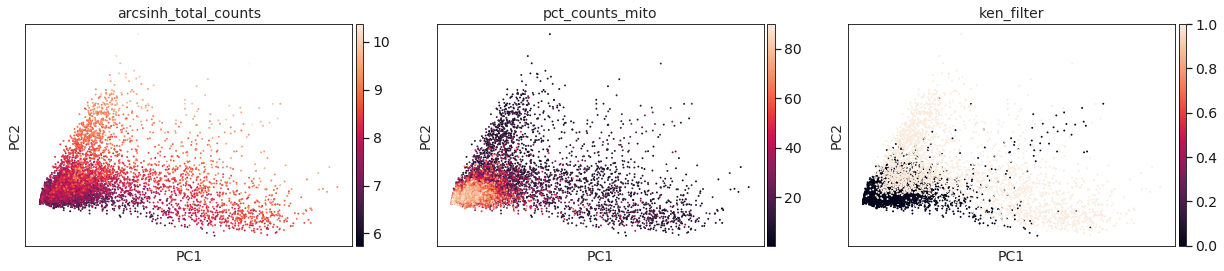

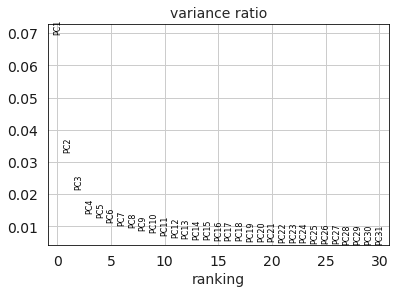

CPU times: user 1min 56s, sys: 47.2 s, total: 2min 43s
Wall time: 8.42 s


In [45]:
%%time
# perform PCA on arcsinh-normalized counts
s1.X = s1.layers['arcsinh_norm'].copy()
sc.tl.pca(s1, n_comps=500)
sc.pl.pca(s1, color=['arcsinh_total_counts','pct_counts_mito','ken_filter'])
sc.pl.pca_variance_ratio(s1)

## Thresholding
Let's try employing automated threshold picking from [scikit-image](https://scikit-image.org/docs/dev/api/skimage.filters.html) to determine the cutoff between our __empty__ and __non-empty__ droplets.

In [46]:
from skimage.filters import threshold_li, threshold_otsu, threshold_isodata, threshold_mean, threshold_yen, threshold_triangle # popular thresholding methods

In [47]:
def colArray(adata, norm):
    counts_array = np.array(adata.obs[norm + '_total_counts'])
    genes_array = np.array(adata.obs[norm + '_n_genes_by_counts'])
    mito_array = np.array(adata.obs['pct_counts_mito'])
    
    return (counts_array, genes_array, mito_array)

### Qualitative Comparison

For the total counts and genes count histogram, we want the threshold cutoff to be as far left as possible, since it is safer to assume that an unknown cell is non-empty rather than empty.

In [48]:
# plot the thresholding methods for a visual representation
def plotThreshold(adata, filterMethod, norm):
    fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(12,4), sharey=True)
    axes[0].hist(adata.obs[norm + '_total_counts'], bins=50)
    axes[0].axvline(filterMethod(colArray(adata, norm)[0]), color='r')
    axes[1].hist(adata.obs[norm + '_n_genes_by_counts'], bins=50)
    axes[1].axvline(filterMethod(colArray(adata, norm)[1]), color='g')
    axes[2].hist(adata.obs['pct_counts_mito'], bins=50)
    axes[2].axvline(filterMethod(colArray(adata, norm)[2]), color='k')
    plt.tight_layout()
    
    print("red = total counts, green = genes count, black = mito count")

red = total counts, green = genes count, black = mito count


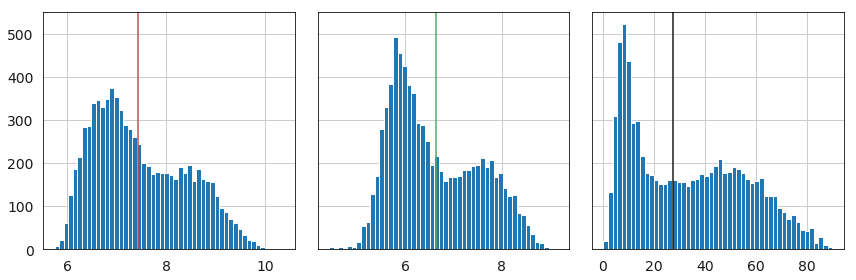

In [49]:
#test threshold_li
plotThreshold(s1, threshold_li, 'arcsinh')

red = total counts, green = genes count, black = mito count


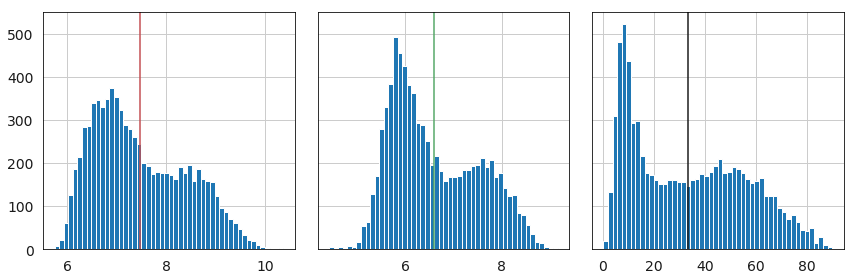

In [50]:
# test threshold_mean
plotThreshold(s1, threshold_mean, 'arcsinh')

### Quantitative Comparison
We want the difference in cell count between the threshold and Ken's filter to be as low as possible.

In [51]:
# assign a column for thresh_filter in the AnnData object
def addThreshCol(adata, filterMethod, filterName, norm):
    adata.obs[filterName] = 1
    adata.obs.loc[(adata.obs[norm + '_n_genes_by_counts'] >= filterMethod(colArray(adata, norm)[1])) & (adata.obs[norm + '_total_counts'] >= filterMethod(colArray(adata, norm)[0])) & (adata.obs['pct_counts_mito'] <= filterMethod(colArray(adata, norm)[2])), filterName] = 0

In [14]:
# assign a column for thresh_filter in the AnnData object
def addThreshColNoMito(adata, filterMethod, filterName, norm):
    adata.obs[filterName] = 1
    adata.obs.loc[(adata.obs[norm + '_n_genes_by_counts'] >= filterMethod(colArray(adata, norm)[1])) & (adata.obs[norm + '_total_counts'] >= filterMethod(colArray(adata, norm)[0])), filterName] = 0

In [15]:
addThreshColNoMito(s1, threshold_li, 'thresh_li_arcsinh', 'arcsinh')
addThreshColNoMito(s1, threshold_mean, 'thresh_mean_arcsinh', 'arcsinh')

In [52]:
addThreshCol(s1, threshold_li, 'thresh_li_arcsinh', 'arcsinh')
addThreshCol(s1, threshold_mean, 'thresh_mean_arcsinh', 'arcsinh')

In [53]:
# calculate the set difference between the threshold method and ken's filter, or the difference between the threshold method and another method
def findDifference(adata, filterName1, filterName2, doPrint = 'p'):
    filter1Index = adata.obs.loc[adata.obs[filterName1] == 0].index
    filter2Index = adata.obs.loc[adata.obs[filterName2] == 0].index
    
    filter1DifFilter2 = len(set(filter1Index).difference(set(filter2Index))) # elements present in filter1 but not in filter2
    filter2DifFilter1 = len(set(filter2Index).difference(set(filter1Index))) # elements present in filter2 but not in filter1
    
    if (doPrint.lower() == 'p'):
        print("Elements present in ", filterName1, " but not in ", filterName2, ": ", filter1DifFilter2)
        print("Elements present in ", filterName2, " but not in ", filterName1, ": ", filter2DifFilter1)
        
    return (filter1DifFilter2, filter2DifFilter1)

In [54]:
findDifference(s1, 'thresh_li_arcsinh', 'ken_filter_reverse')
print()
findDifference(s1, 'thresh_mean_arcsinh', 'ken_filter_reverse')

Elements present in  thresh_li_arcsinh  but not in  ken_filter_reverse :  141
Elements present in  ken_filter_reverse  but not in  thresh_li_arcsinh :  279

Elements present in  thresh_mean_arcsinh  but not in  ken_filter_reverse :  189
Elements present in  ken_filter_reverse  but not in  thresh_mean_arcsinh :  212


(189, 212)

## Training
Now, we want to generate a training set from the barcodes __below__ our `log1p_total_counts` threshold.  
To do so, we will randomly sample a reasonable number of barcodes (>1000), with probabilities __decreasing__ with __increasing total counts__.

In [55]:
# calculate probability of labeling an empty cell as non-empty based on the threshold
def calcCountsProb(adata, filterMethod, probName, norm):
    # initialize 'probabilities' column with all zeros. we want probability of drawing a barcode ABOVE our threshold to be ZERO
    adata.obs[probName] = 0
    
    thresh_counts = filterMethod(colArray(adata, norm)[0])
    # of all the barcodes BELOW our threshold (using mean here), take the reciprocal of their total counts and normalize to the sum
    adata.obs.loc[adata.obs[norm + '_total_counts'] < thresh_counts, probName] = np.reciprocal(adata.obs.loc[adata.obs[norm + '_total_counts'] < thresh_counts, 'total_counts'] + 1)
    adata.obs[probName] /= adata.obs[probName].sum()

In [56]:
# calculate probability of labeling an empty cell as non-empty based on the threshold
def calcGenesProb(adata, filterMethod, probName, norm):
    # initialize 'probabilities' column with all zeros. we want probability of drawing a barcode ABOVE our threshold to be ZERO
    adata.obs[probName] = 0
    
    thresh_genes = filterMethod(colArray(adata, norm)[1])
    # of all the barcodes BELOW our threshold (using mean here), take the reciprocal of their total counts and normalize to the sum
    adata.obs.loc[adata.obs[norm + '_n_genes_by_counts'] < thresh_genes, probName] = np.reciprocal(adata.obs.loc[adata.obs[norm + '_n_genes_by_counts'] < thresh_genes, norm + '_n_genes_by_counts'] + 1)
    adata.obs[probName] /= adata.obs[probName].sum()

In [57]:
# calculate probability of labeling an empty cell as non-empty based on the threshold
def calcMitoProb(adata, filterMethod, probName, norm):
    # initialize 'probabilities' column with all zeros. we want probability of drawing a barcode ABOVE our threshold to be ZERO
    adata.obs[probName] = 0
    
    thresh_mito = filterMethod(colArray(adata, norm)[2])
    # of all the barcodes BELOW our threshold (using mean here), take the reciprocal of their total counts and normalize to the sum
    adata.obs.loc[adata.obs['pct_counts_mito'] > thresh_mito, probName] = adata.obs.loc[adata.obs['pct_counts_mito'] > thresh_mito, 'pct_counts_mito']
    adata.obs[probName] /= adata.obs[probName].sum()

In [58]:
calcCountsProb(s1, threshold_li, 'counts_prob_li', 'arcsinh')
calcGenesProb(s1, threshold_li, 'genes_prob_li', 'arcsinh')
calcMitoProb(s1, threshold_li, 'mito_prob_li', 'arcsinh')

In [59]:
calcCountsProb(s1, threshold_mean, 'counts_prob_mean', 'arcsinh')
calcGenesProb(s1, threshold_mean, 'genes_prob_mean', 'arcsinh')
calcMitoProb(s1, threshold_mean, 'mito_prob_mean', 'arcsinh')

In [60]:
def plotCountsProb(adata, filterMethod, probName, norm):
    new_order = np.argsort(adata.obs['total_counts'])[::-1]
    adata = adata[new_order, :].copy()

    # there should be a dropoff to ZERO at the threshold value we chose
    fig, ax1 = plt.subplots(figsize=(5,3))

    color = 'tab:blue'
    ax1.set_xlabel(norm + '_total_counts')
    ax1.set_ylabel('density', color=color)
    ax1.hist(adata.obs[norm + '_total_counts'], bins=50, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:red'
    ax2.set_ylabel(probName, color=color)  # we already handled the x-label with ax1
    ax2.plot(adata.obs[norm + '_total_counts'], adata.obs[probName], color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.axvline(filterMethod(colArray(adata, norm)[0]), color='g') # mean threshold

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

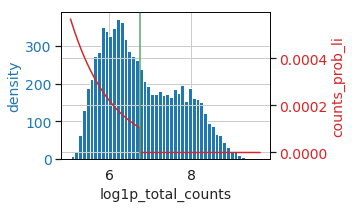

In [61]:
plotCountsProb(s1, threshold_li, 'counts_prob_li', 'log1p')

In [62]:
def plotGenesProb(adata, filterMethod, probName, norm):
    new_order = np.argsort(adata.obs[norm + '_n_genes_by_counts'])[::-1]
    adata = adata[new_order, :].copy()

    # there should be a dropoff to ZERO at the threshold value we chose
    fig, ax1 = plt.subplots(figsize=(5,3))

    color = 'tab:blue'
    ax1.set_xlabel(norm + '_n_genes_by_counts')
    ax1.set_ylabel('density', color=color)
    ax1.hist(adata.obs[norm + '_n_genes_by_counts'], bins=50, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:red'
    ax2.set_ylabel(probName, color=color)  # we already handled the x-label with ax1
    ax2.plot(adata.obs[norm + '_n_genes_by_counts'], adata.obs[probName], color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    
    plt.axvline(filterMethod(colArray(adata, norm)[1]), color='g') # mean threshold

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

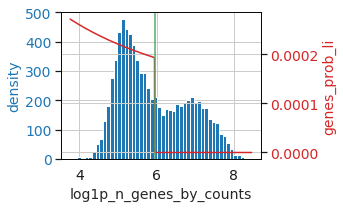

In [63]:
plotGenesProb(s1, threshold_li, 'genes_prob_li', 'log1p')

In [64]:
def plotMitoProb(adata, filterMethod, probName, norm):
    new_order = np.argsort(adata.obs['pct_counts_mito'])[:]
    adata = adata[new_order, :].copy()

    # there should be a dropoff to ZERO at the threshold value we chose
    fig, ax1 = plt.subplots(figsize=(5,3))

    color = 'tab:blue'
    ax1.set_xlabel('pct_counts_mito')
    ax1.set_ylabel('density', color=color)
    ax1.hist(adata.obs['pct_counts_mito'], bins=50, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:red'
    ax2.set_ylabel(probName, color=color)  # we already handled the x-label with ax1
    ax2.plot(adata.obs['pct_counts_mito'], adata.obs[probName], color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.axvline(filterMethod(colArray(adata, norm)[2]), color='g')

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

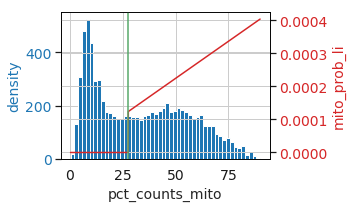

In [65]:
plotMitoProb(s1, threshold_li, 'mito_prob_li', 'log1p')

In [66]:
def calcTrainProb(adata, trainProbName, countsProbName, genesProbName, mitoProbName):
    adata.obs[trainProbName] = adata.obs[countsProbName] + adata.obs[genesProbName] + adata.obs[mitoProbName]
    adata.obs[trainProbName] /= adata.obs[trainProbName].sum()

In [30]:
def calcTrainProbNoMito(adata, trainProbName, countsProbName, genesProbName):
    adata.obs[trainProbName] = adata.obs[countsProbName] + adata.obs[genesProbName]
    adata.obs[trainProbName] /= adata.obs[trainProbName].sum()

In [67]:
calcTrainProb(s1, 'train_prob_li_arcsinh', 'counts_prob_li', 'genes_prob_li', 'mito_prob_li')
calcTrainProb(s1, 'train_prob_mean_arcsinh', 'counts_prob_mean', 'genes_prob_mean', 'genes_prob_mean')

In [32]:
calcTrainProbNoMito(s1, 'train_prob_li_arcsinh', 'counts_prob_li', 'genes_prob_li')
calcTrainProbNoMito(s1, 'train_prob_mean_arcsinh', 'counts_prob_mean', 'genes_prob_mean')

In [68]:
def sampleTrain(adata, trainName, sampleSize, probName, threshName):
    sampleFromTotal = int(round(adata.shape[0] * sampleSize))
    sampleFromProb = int(round((adata.obs[threshName].sum()) * sampleSize))
    # now randomly sample a training set using s1.obs['train_prob'] from above as the vector of probabilities.
    # save sample as label in adata.obs['train']
    adata.obs[trainName] = 0
    adata.obs.iloc[np.random.choice(a=adata.obs.shape[0], size=sampleFromProb, replace=False, p=s1.obs[probName]), adata.obs.columns.get_loc(trainName)] = 1

In [69]:
sampleTrain(s1, 'train_li_arcsinh', 0.2, 'train_prob_li_arcsinh', 'thresh_li_arcsinh')
sampleTrain(s1, 'train_mean_arcsinh', 0.2, 'train_prob_mean_arcsinh', 'thresh_mean_arcsinh')

## Bagging
This method will use **bagging** for **positive-unlabeled** classifier learning [(Mordelet and Vert, 2014)](https://www.sciencedirect.com/science/article/pii/S0167865513002432?via%3Dihub)
1. Choose datapoints (droplets) that are confidently positive for the given label (in our case, empty droplets and dead cells)
2. Randomly choose other datapoints to also be positive, and make all others negative
3. Rinse and repeat, aggregating classification scores

In [36]:
def baggingPU(adata, trainName, decisionFunctionName, bagFilterName, decisionThreshName):
    # define X and y for classifier training for simplicity
    X = adata.obsm['X_pca'] # training data is PCA results
    y = adata.obs[trainName].copy(deep=True) # training labels are from .obs df
    
    bc = BaggingClassifierPU(
        DecisionTreeClassifier(),
        n_estimators = 1000,  # 1000 trees as usual
        max_samples = sum(y), # Balance the positives and unlabeled in each bag
        n_jobs = -1           # Use all cores
    )
    bc.fit(X, y)
    results_bagging = bc.oob_decision_function_[:,1]
    
    adata.obs[decisionFunctionName] = bc.oob_decision_function_[:,1]
    adata.obs[bagFilterName] = bc.predict(X)
    
    # make decision function results binary
    adata.obs[decisionThreshName] = 0
    adata.obs.loc[adata.obs[decisionFunctionName] > 0.5, decisionThreshName] = 1

In [98]:
baggingPU(s1, 'train_li_arcsinh', 'decision_function_li_arcsinh', 'bag_filter_li_arcsinh', 'decision_thresh_li_arcsinh')
baggingPU(s1, 'train_mean_arcsinh', 'decision_function_mean_arcsinh', 'bag_filter_mean_arcsinh', 'decision_thresh_mean_arcsinh')

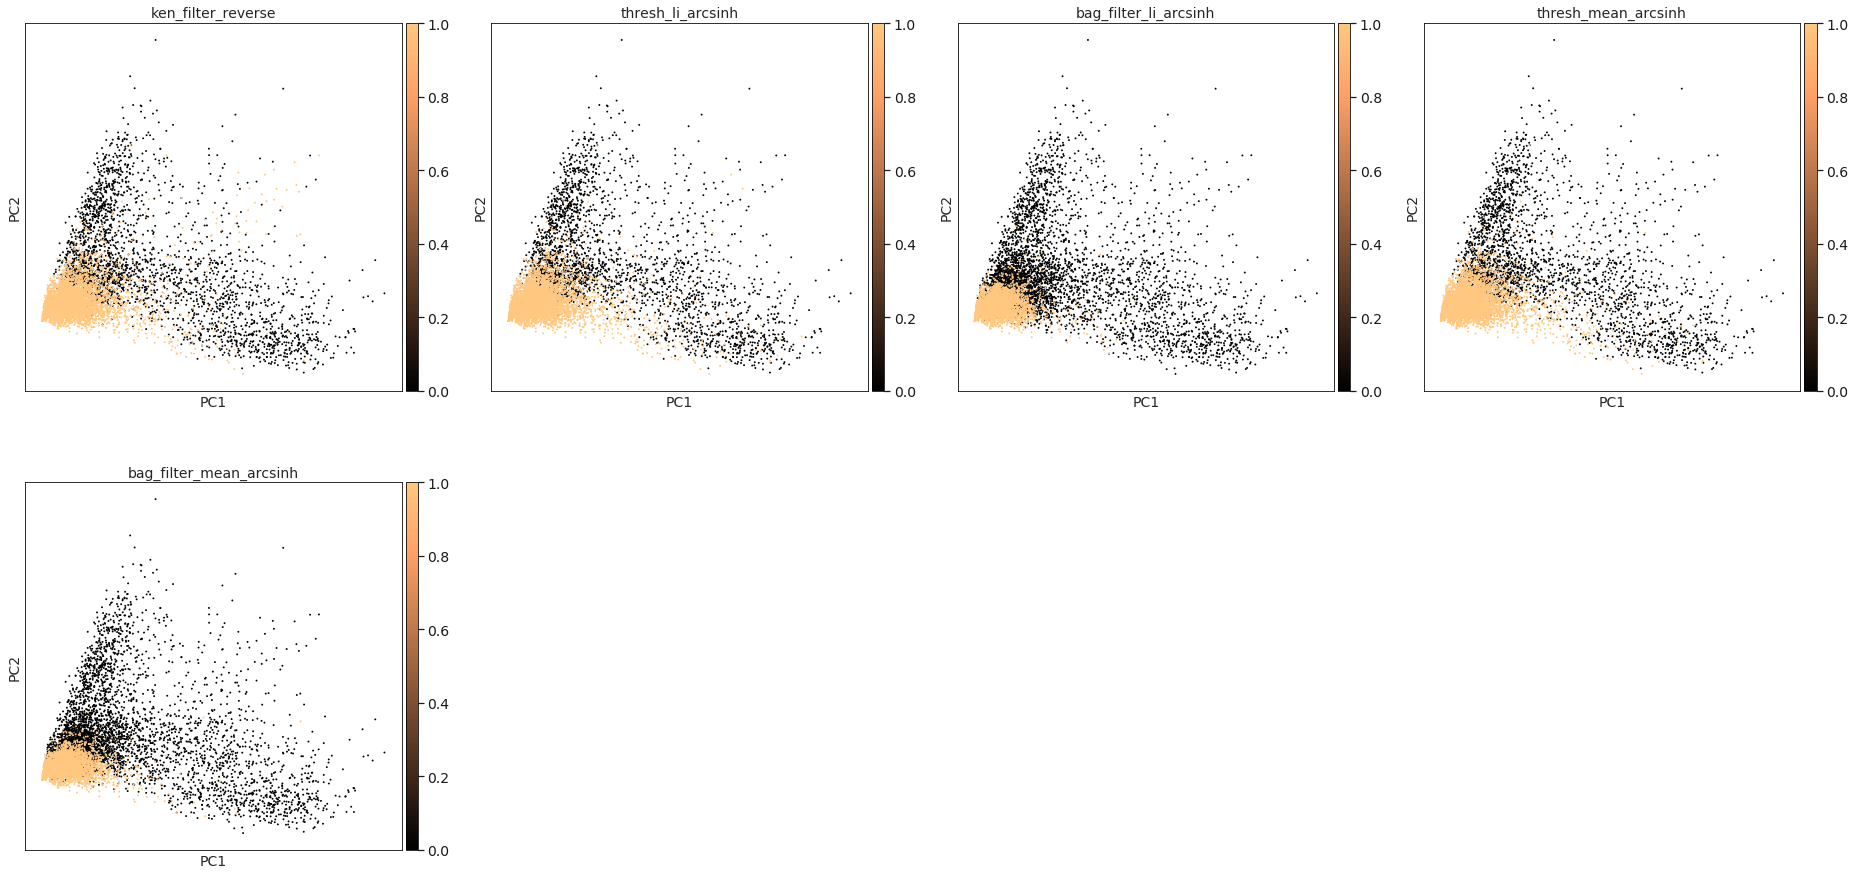

In [109]:
sc.pl.pca(s1, color=['ken_filter_reverse','thresh_li_arcsinh','bag_filter_li_arcsinh', 'thresh_mean_arcsinh', 'bag_filter_mean_arcsinh'], cmap = 'copper')

In [39]:
findDifference(s1, 'ken_filter_reverse', 'thresh_li_arcsinh')
print()
findDifference(s1, 'ken_filter_reverse', 'bag_filter_li_arcsinh')
print()
findDifference(s1, 'ken_filter_reverse', 'thresh_mean_arcsinh')
print()
findDifference(s1, 'ken_filter_reverse', 'bag_filter_mean_arcsinh')

Elements present in  ken_filter_reverse  but not in  thresh_li_arcsinh :  10
Elements present in  thresh_li_arcsinh  but not in  ken_filter_reverse :  1598

Elements present in  ken_filter_reverse  but not in  bag_filter_li_arcsinh :  7
Elements present in  bag_filter_li_arcsinh  but not in  ken_filter_reverse :  7978

Elements present in  ken_filter_reverse  but not in  thresh_mean_arcsinh :  1
Elements present in  thresh_mean_arcsinh  but not in  ken_filter_reverse :  2693

Elements present in  ken_filter_reverse  but not in  bag_filter_mean_arcsinh :  0
Elements present in  bag_filter_mean_arcsinh  but not in  ken_filter_reverse :  8061


(0, 8061)

In [87]:
def plotResults(adata, bagFilterName, plotTitle):
    # visualize PU bagging results
    plt.rcParams['figure.figsize'] = 7,7
    plt.scatter(
        adata.obsm['X_pca'][:,0], adata.obsm['X_pca'][:,1], 
        c = adata.obs[bagFilterName], linewidth = 0, s = 50, alpha = 0.5, 
        cmap = 'jet_r'
    )
    plt.colorbar(label='Scores given to unlabeled points')
    plt.title(plotTitle)
    plt.show()

## TwoStep
This method will use a **2-step method** for **positive-unlabeled** classifier learning [(Kaboutari, et al. 2014)](https://www.semanticscholar.org/paper/An-Evaluation-of-Two-Step-Techniques-for-Learning-Kaboutari-Bagherzadeh/bd10ba5f30744e4755cbe7757e8c657ce5d6ec45)
1. Choose datapoints (droplets) that are confidently positive for the given label (in our case, empty droplets and dead cells)
2. Use some method of determining datapoints (droplets) that are confidently negative for the given label (we can use UMI ranking and MT enrichment of clusters)

In [71]:
# reload fcc module while working
import sys
del sys.modules['PU_twostep']
from PU_twostep import *

In [4]:
def twoStepPU(adata, trainName, twoStepLabelName):
    # define X and y for classifier training for simplicity
    X = s1.obsm['X_pca'] # training data is PCA results
    y = s1.obs[trainName].copy(deep=True) # training labels are from .obs df
    
    rf = RandomForestClassifier(n_estimators=1000, n_jobs=-1) # define random forest classifier, you can plug in any classifier though!
    twoStepScore, twoStepLabel = twoStep(clf=rf, X=X, y=y, n_iter=18)
    
    adata.obs[twoStepLabelName] = twoStepLabel

In [2]:
twoStepPU(s1, 'thresh_li_arcsinh', 'twostep_score_li_arcsinh', 'twostep_label_li_arcsinh')
twoStepPU(s1, 'thresh_mean_arcsinh', 'twostep_score_mean_arcsinh', 'twostep_label_mean_arcsinh')

NameError: name 's1' is not defined

In [ ]:
findDifference(s1, 'twostep_label_li_arcsinh', 'ken_filter_reverse')
findDifference(s1, 'twostep_label_mean_arcsinh', 'ken_filter_reverse')

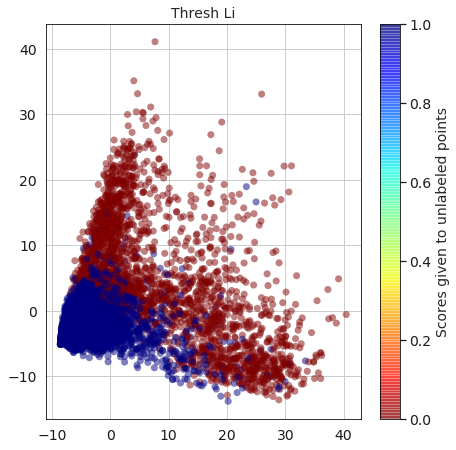

In [91]:
plotResults(s1, 'thresh_li_arcsinh', 'Thresh Li')

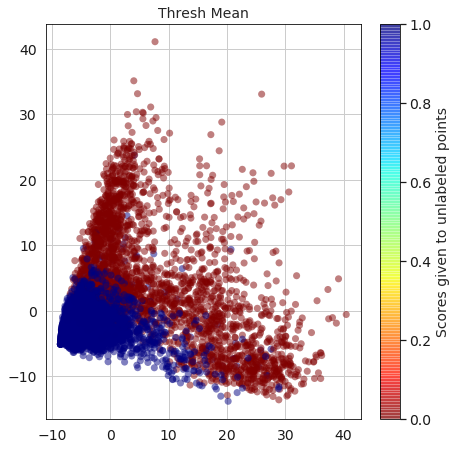

In [92]:
plotResults(s1, 'thresh_mean_arcsinh', 'Thresh Mean')

In [93]:
plotResults(s1, 'bag_filter_li_arcsinh', 'PU Bagging')

KeyError: 'bag_filter_li_arcsinh'

In [94]:
plotResults(s1, 'bag_filter_mean_arcsinh', 'PU Bagging')

KeyError: 'bag_filter_mean_arcsinh'

In [95]:
plotResults(s1, 'twostep_label_li_arcsinh', 'Two-Step Method')

KeyError: 'twostep_label_li_arcsinh'

In [96]:
plotResults(s1, 'twostep_label_mean_arcsinh', 'Two-Step Method')

KeyError: 'twostep_label_mean_arcsinh'

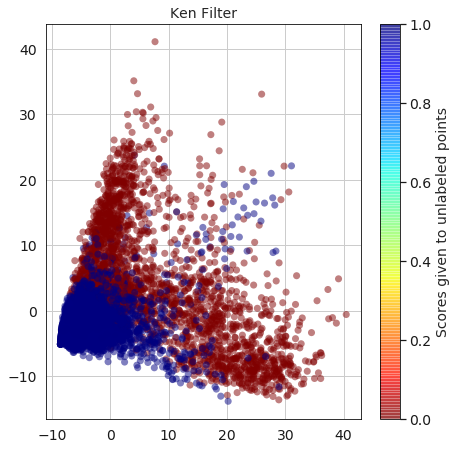

In [97]:
plotResults(s1, 'ken_filter_reverse', 'Ken Filter')